In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


In [13]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [14]:
df = pd.read_csv('/content/mergedDatas.csv')

In [15]:
df.head()

,text,label
0,nigerian soldier battle haram killing rescued ...,1
1,Green capital attacker supporter nation islam,1
2,raid of osama bin laden,1
3,terrorist attack austria,1
4,soldier receives medal captive execution islam...,1


In [16]:
df.tail()

,text,label
7762,unidentified gunmen shot killed chechen family...,1
7763,david brown suffered severe hand eye injuries ...,1
7764,approximately six algerian rebels burst lycee ...,1
7765,two land mines detonated northern takhar provi...,1
7766,suspected national union total independence an...,1


In [17]:
text = df['text']
label = df['label']
     


In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
     

In [19]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [20]:
sequence = tokenizer.texts_to_sequences(text)
padded_sequence = pad_sequences(sequence,padding='post')

In [21]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequence,label,test_size=0.3,shuffle=True,random_state = 42)

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-04-19 12:04:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-19 12:04:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-19 12:04:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [22]:
embeddings_index = {};
with open('/content/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size,100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [23]:
with tf.device(device_name):
  model = Sequential()
  model.add(Embedding(vocab_size,100,weights=[embeddings_matrix],trainable=False))
  model.add(Bidirectional(LSTM(32,return_sequences=True)))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
     

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1906800   
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         34048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,967,793
Trainable params: 60,993
Non-tra

In [25]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [26]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
170/170 [==============================] - 82s 405ms/step - loss: 0.0740 - accuracy: 0.9742 - val_loss: 0.0357 - val_accuracy: 0.9888
Epoch 2/10
170/170 [==============================] - 66s 386ms/step - loss: 0.0253 - accuracy: 0.9926 - val_loss: 0.0342 - val_accuracy: 0.9876
Epoch 3/10
170/170 [==============================] - 66s 389ms/step - loss: 0.0165 - accuracy: 0.9958 - val_loss: 0.0336 - val_accuracy: 0.9901
Epoch 4/10
170/170 [==============================] - 76s 444ms/step - loss: 0.0108 - accuracy: 0.9972 - val_loss: 0.0484 - val_accuracy: 0.9858
Epoch 5/10
170/170 [==============================] - 76s 446ms/step - loss: 0.0068 - accuracy: 0.9983 - val_loss: 0.0439 - val_accuracy: 0.9893
Epoch 6/10
170/170 [==============================] - 66s 390ms/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.0478 - val_accuracy: 0.9897
Epoch 7/10
170/170 [==============================] - 76s 450ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0576 - val_ac

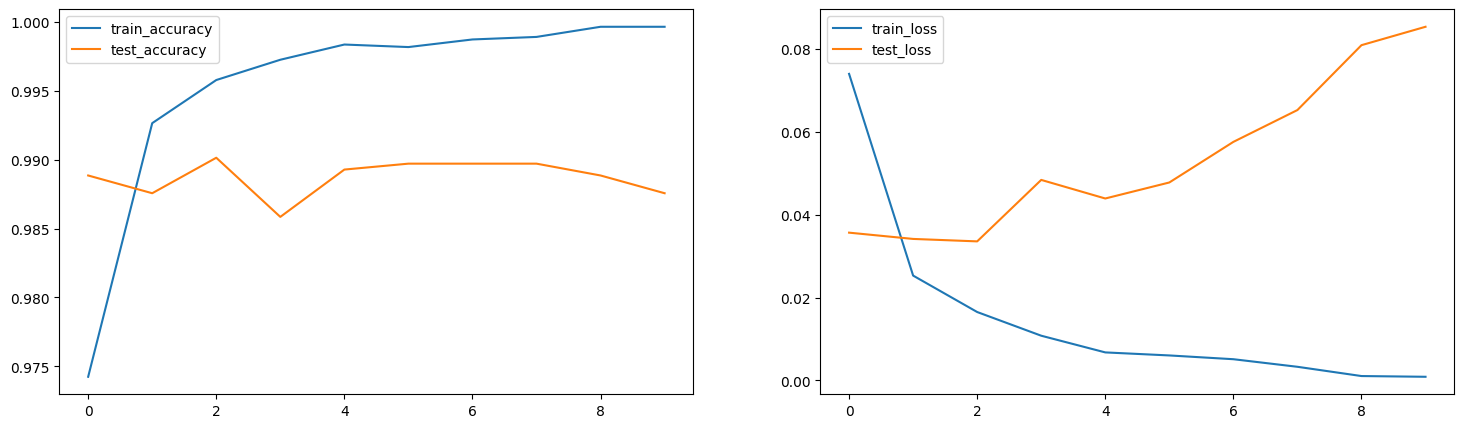

In [28]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(18,5))
ax1.plot(history.history['accuracy'],label='train_accuracy')
ax1.plot(history.history['val_accuracy'],label='test_accuracy')
ax1.legend()
ax2.plot(history.history['loss'],label='train_loss')
ax2.plot(history.history['val_loss'],label='test_loss')
ax2.legend()
plt.show()

In [29]:
model.evaluate(x_test,y_test)

73/73 [==============================] - 12s 167ms/step - loss: 0.0854 - accuracy: 0.9876


[0.08537506312131882, 0.9875589609146118]

In [30]:
model.save('./lstm.h5')

In [31]:
pred = model.predict(x_test)
     

73/73 [==============================] - 15s 164ms/step


In [32]:
pred = pred>0.5

In [33]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

       False       0.98      0.96      0.97       437
        True       0.99      0.99      0.99      1894

    accuracy                           0.99      2331
   macro avg       0.98      0.98      0.98      2331
weighted avg       0.99      0.99      0.99      2331

